In [37]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import plot_tree, export_text

from pprint import pprint

import warnings


In [38]:
warnings.filterwarnings("ignore")

## Setup

In [39]:
#read file
uavsar_pits = pd.read_csv('/home/naheemadebisi/PhD/snow-analytics/Radar-Backscatter/pits_data/uavsar_SWE_ENV.csv')
#drop null
uavsar_pits.dropna(inplace = True)
uavsar_pits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 285
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             261 non-null    int64  
 1   Location               261 non-null    object 
 2   PitID                  261 non-null    object 
 3   Density Mean (kg/m^3)  261 non-null    float64
 4   Snow Depth (cm)        261 non-null    float64
 5   SWE (mm)               261 non-null    float64
 6   HH                     261 non-null    float64
 7   HV                     261 non-null    float64
 8   VH                     261 non-null    float64
 9   VV                     261 non-null    float64
 10  Temp_mean              261 non-null    float64
 11  Ground Condition       261 non-null    object 
 12  Ground Roughness       261 non-null    object 
 13  Ground Vegetation      261 non-null    object 
 14  Canopy                 261 non-null    object 
dtypes: flo

In [40]:
#train-test split
train_df , test_df = train_test_split(uavsar_pits, test_size= 0.25, random_state= 20221104)
print(f"lenth of the training data is {len(train_df)}")
print(f"lenth of the testdata is {len(test_df)}")

lenth of the training data is 195
lenth of the testdata is 66


In [41]:
#input and output data
input_cols = ['Density Mean (kg/m^3)', 'Snow Depth (cm)', 'SWE (mm)', 'Temp_mean',
       'Ground Condition', 'Ground Roughness', 'Canopy']
target_col = 'HH'

train_inputs = train_df[input_cols].copy()
train_target = train_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_target = test_df[target_col].copy()



#select the four numerical cols(Density, Depth, SWE, temp)
num_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
#Select the four categorical cols (Ground Condition, Ground Roughness, Ground Vegetation, Canopy)
cat_cols = train_inputs.select_dtypes('object').columns.tolist()


In [42]:
#let's see some stats for the numerical columns
train_inputs[num_cols].describe()

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean
count,195.000000,195.000000,195.000000,195.000000
mean,250.743590,113.123077,299.448718,-4.112674
std,72.657319,55.229304,203.338122,2.678310
min,75.000000,22.000000,55.000000,-16.250000
25%,205.250000,73.500000,134.000000,-5.506250
50%,268.000000,106.000000,260.000000,-3.831250
75%,299.000000,135.000000,389.750000,-2.151429
max,436.500000,284.000000,969.000000,0.000000


In [43]:
#let's check the categories in each category
train_inputs[cat_cols].nunique()

Ground Condition    3
Ground Roughness    3
Canopy              4
dtype: int64

## Modelling

Todo: redo steps following jovian!

In [45]:
#initiate the columnTransformer
column_trans = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include=object)),
    remainder = "passthrough")


In [10]:
# #initiate the columnTransformer
# column_trans = ColumnTransformer((
#                 ('categories', OneHotEncoder(), make_column_selector(dtype_include= object)),
#                 ('scaler', StandardScaler(), make_column_selector(dtype_include= np.number))
#                       ))

In [9]:
# #Put transformer and predictor in a pipeline
# rf = Pipeline([
#             ('features', column_trans),
#             ('pred', RandomForestRegressor())
#             ])
# param_grid = dict(pred__n_estimators = [1, 3, 5, 7,10], pred__max_depth = [1, 3, 5, 7], 
#                 pred__max_leaf_nodes = [1, 3, 5, 7, 10],  pred__max_features = [ None, 'sqrt', 'log2'],
#                   pred__min_samples_split = [1, 2, 4, 8, 16, 32],  pred__min_samples_leaf = [1, 2, 4, 8, 16, 32], pred__bootstrap = [True, False])

# rf_gs = GridSearchCV(rf, param_grid= param_grid, n_jobs = -1)

In [46]:
#Put transformer and predictor in a pipeline
rf = Pipeline([
    ('features', column_trans),
    ('pred', RandomForestRegressor())
])
param_grid = dict(pred__n_estimators=[1, 3, 5, 7, 10], pred__max_depth=[1, 3, 5, 7],
                  pred__max_leaf_nodes=[1, 3, 5, 7, 10])

rf_gs = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1)


In [47]:
rf_gs.fit(train_inputs, train_target)

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0149d9a640>)])),
                                       ('pred', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'pred__max_depth': [1, 3, 5, 7],
                         'pred__max_leaf_nodes': [1, 3, 5, 7, 10],
                         'pred__n_estimators': [1, 3, 5, 7, 10]})

In [48]:
rf_gs.best_estimator_.score(train_inputs, train_target)


0.3716696504616661

In [19]:
# #predict train
# predictions_train = rf_gs.best_estimator_.predict(train_inputs)
# #predict test
# predictions_test = rf_gs.best_estimator_.predict(test_inputs)

# #compute loss train
# mse_loss = mse(train_target, predictions_train)
# rsquare = r2_score(train_target, predictions_train) 
# print(f'Train mse: {mse_loss}')
# print(f'Train r_square: {rsquare}')

# #compute loss test
# mse_loss = mse(test_target, predictions_test)
# rsquare = r2_score(test_target, predictions_test) 
# print(f'Test mse: {mse_loss}')
# print(f'Test r_square: {rsquare}')
#print(predictions_test)


In [50]:
rf_gs.best_params_

{'pred__max_depth': 1, 'pred__max_leaf_nodes': 5, 'pred__n_estimators': 3}

In [64]:
def feature_importance(fitted_model):
    #feature importance
    importance_df = pd.DataFrame({
        'feature': fitted_model.named_steps["features"].get_feature_names(),
    'importance': fitted_model.named_steps["pred"].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.title('Feature Importance')
    sns.barplot(data=importance_df.head(10), x='importance', y='feature');


In [65]:
rf_gs.best_estimator_.named_steps["features"].get_feature_names()


['onehotencoder__x0_Frozen',
 'onehotencoder__x0_Moist',
 'onehotencoder__x0_Saturated',
 'onehotencoder__x1_Rough',
 'onehotencoder__x1_Rugged',
 'onehotencoder__x1_Smooth',
 'onehotencoder__x2_Closed (>70%)',
 'onehotencoder__x2_No Trees',
 'onehotencoder__x2_Open (20-70%)',
 'onehotencoder__x2_Sparse (5-20%)',
 'Density Mean (kg/m^3)',
 'Snow Depth (cm)',
 'SWE (mm)',
 'Temp_mean']

In [66]:
rf_gs.best_estimator_.named_steps["pred"].feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

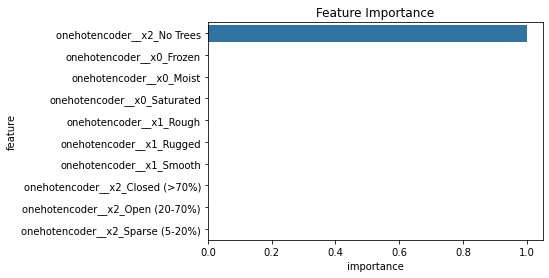

In [67]:
feature_importance(rf_gs.best_estimator_)